In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("/home/mdafifal.mamun/notebooks/triagerX/data/openj9/last_contribution/openj9_dataset_6_7_24_last_contrib.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/mdafifal.mamun/notebooks/triagerX/data/openj9/last_contribution/openj9_dataset_6_7_24_last_contrib.csv'

In [ ]:
df = pd.read_csv("D:\\Triager X\\triagerX\\data\\openj9_dataset_6_7_24.csv")

In [7]:
from sklearn.model_selection import train_test_split
from loguru import logger

test_size=0.1

df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df.sort_values(by="issue_number")
df = df[df["owner"].notna()]

num_issues = len(df)
logger.info(f"Total number of issues after processing: {num_issues}")

df = df.sort_values(by="issue_number")

df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

unwanted = list(test_owners - train_owners)

df_test = df_test[~df_test["owner"].isin(unwanted)]

logger.info(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
logger.info(f"Number of developers: {len(df_train.owner.unique())}")

logger.info(f"Train dataset size: {len(df_train)}")
logger.info(f"Test dataset size: {len(df_test)}")

2024-07-04 16:48:35.858 | INFO     | __main__:<module>:11 - Total number of issues after processing: 4510
2024-07-04 16:48:35.872 | INFO     | __main__:<module>:29 - Training data: 3332, Validation data: 380
2024-07-04 16:48:35.876 | INFO     | __main__:<module>:30 - Number of developers: 45
2024-07-04 16:48:35.877 | INFO     | __main__:<module>:32 - Train dataset size: 3332
2024-07-04 16:48:35.878 | INFO     | __main__:<module>:33 - Test dataset size: 380


In [8]:
lbl2idx = {}
idx2lbl = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx
    idx2lbl[idx] = dev

df_train["owner_id"] = df_train["owner"].apply(lambda owner: lbl2idx[owner])
df_test["owner_id"] = df_test["owner"].apply(lambda owner: lbl2idx[owner])

In [10]:
import numpy as np

In [11]:
class_counts = np.bincount(df_train["owner_id"])
num_samples = sum(class_counts)
labels = df_train["owner_id"].to_list()  # corresponding labels of samples

class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]

In [21]:
import torch

In [22]:
labels

[5,
 37,
 41,
 22,
 28,
 22,
 42,
 29,
 42,
 38,
 30,
 1,
 41,
 30,
 19,
 14,
 25,
 42,
 42,
 5,
 42,
 5,
 1,
 37,
 22,
 25,
 4,
 8,
 22,
 25,
 20,
 21,
 5,
 5,
 30,
 30,
 33,
 33,
 34,
 22,
 33,
 33,
 33,
 38,
 38,
 35,
 8,
 23,
 26,
 28,
 25,
 38,
 8,
 38,
 8,
 4,
 5,
 33,
 17,
 1,
 25,
 21,
 25,
 9,
 30,
 37,
 1,
 26,
 37,
 20,
 35,
 25,
 25,
 25,
 5,
 43,
 25,
 0,
 8,
 37,
 8,
 38,
 8,
 1,
 8,
 22,
 7,
 37,
 32,
 8,
 31,
 5,
 4,
 8,
 23,
 5,
 5,
 8,
 8,
 1,
 1,
 22,
 5,
 43,
 38,
 37,
 8,
 41,
 37,
 36,
 37,
 37,
 43,
 41,
 43,
 8,
 22,
 22,
 43,
 5,
 22,
 37,
 41,
 5,
 38,
 8,
 8,
 8,
 1,
 33,
 8,
 8,
 37,
 8,
 37,
 8,
 42,
 5,
 16,
 8,
 8,
 38,
 30,
 38,
 30,
 38,
 38,
 22,
 22,
 30,
 41,
 1,
 1,
 38,
 38,
 37,
 19,
 44,
 11,
 38,
 38,
 38,
 28,
 38,
 38,
 1,
 33,
 9,
 25,
 42,
 8,
 22,
 35,
 38,
 5,
 41,
 1,
 37,
 5,
 5,
 1,
 8,
 8,
 41,
 8,
 20,
 25,
 44,
 5,
 37,
 43,
 37,
 38,
 25,
 41,
 11,
 30,
 17,
 5,
 43,
 8,
 21,
 21,
 21,
 21,
 21,
 21,
 37,
 25,
 17,
 41,
 5,
 5,
 8,


In [24]:
class_counts = torch.bincount(torch.tensor(labels))
total_samples = len(labels)

# Calculate class weights (inverse of class frequency)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = class_weights.float()

In [30]:
target = df_train.owner_id

In [31]:
class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])

In [33]:
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

In [34]:
samples_weight

array([0.01315789, 0.01086957, 0.04      , ..., 0.02439024, 0.00568182,
       0.00934579])

In [45]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Example dataset and weights
data = [1, 2, 3, 4, 5, 6]
labels = [0, 0, 1, 1, 1, 1]  # Imbalanced classes
weights = [0.1, 0.1, 0.2, 0.3, 0.3, 0.3]  # Sample weights

class_sample_count = np.array(
    [len(np.where(labels == t)[0]) for t in np.unique(labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])

# Create sampler with replacement
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=False)

# Create DataLoader with sampler
data_loader = DataLoader(data, sampler=sampler, batch_size=5)

# Iterate over DataLoader
for batch in data_loader:
    print(batch)

tensor([6, 3, 5, 2, 4])
tensor([1])


In [25]:
class_weights

tensor([2.1778, 0.8511, 2.8479, 2.6444, 0.7120, 0.9743, 3.0852, 2.7424, 0.2092,
        2.6444, 2.2438, 1.5754, 0.8815, 0.4207, 3.5259, 2.2438, 3.5259, 2.3885,
        1.3463, 2.6444, 0.6920, 0.8227, 0.8711, 0.7259, 3.0852, 0.6222, 1.4519,
        1.4519, 1.7220, 1.8060, 0.3010, 0.7404, 2.3885, 0.7633, 1.7220, 0.9616,
        2.8479, 0.8048, 0.2080, 2.8479, 3.0852, 2.9618, 1.0006, 1.3971, 2.3139])

In [18]:
class_counts

array([ 34,  87,  26,  28, 104,  76,  24,  27, 354,  28,  33,  47,  84,
       176,  21,  33,  21,  31,  55,  28, 107,  90,  85, 102,  24, 119,
        51,  51,  43,  41, 246, 100,  31,  97,  43,  77,  26,  92, 356,
        26,  24,  25,  74,  53,  32], dtype=int64)

In [19]:
class_weights

[98.0,
 38.298850574712645,
 128.15384615384616,
 119.0,
 32.03846153846154,
 43.8421052631579,
 138.83333333333334,
 123.4074074074074,
 9.412429378531073,
 119.0,
 100.96969696969697,
 70.8936170212766,
 39.666666666666664,
 18.931818181818183,
 158.66666666666666,
 100.96969696969697,
 158.66666666666666,
 107.48387096774194,
 60.58181818181818,
 119.0,
 31.14018691588785,
 37.022222222222226,
 39.2,
 32.666666666666664,
 138.83333333333334,
 28.0,
 65.33333333333333,
 65.33333333333333,
 77.48837209302326,
 81.26829268292683,
 13.544715447154472,
 33.32,
 107.48387096774194,
 34.350515463917525,
 77.48837209302326,
 43.27272727272727,
 128.15384615384616,
 36.21739130434783,
 9.359550561797754,
 128.15384615384616,
 138.83333333333334,
 133.28,
 45.027027027027025,
 62.867924528301884,
 104.125]

In [20]:
weights

[43.8421052631579,
 36.21739130434783,
 133.28,
 39.2,
 77.48837209302326,
 39.2,
 45.027027027027025,
 81.26829268292683,
 45.027027027027025,
 9.359550561797754,
 13.544715447154472,
 38.298850574712645,
 133.28,
 13.544715447154472,
 119.0,
 158.66666666666666,
 28.0,
 45.027027027027025,
 45.027027027027025,
 43.8421052631579,
 45.027027027027025,
 43.8421052631579,
 38.298850574712645,
 36.21739130434783,
 39.2,
 28.0,
 32.03846153846154,
 9.412429378531073,
 39.2,
 28.0,
 31.14018691588785,
 37.022222222222226,
 43.8421052631579,
 43.8421052631579,
 13.544715447154472,
 13.544715447154472,
 34.350515463917525,
 34.350515463917525,
 77.48837209302326,
 39.2,
 34.350515463917525,
 34.350515463917525,
 34.350515463917525,
 9.359550561797754,
 9.359550561797754,
 43.27272727272727,
 9.412429378531073,
 32.666666666666664,
 65.33333333333333,
 77.48837209302326,
 28.0,
 9.359550561797754,
 9.412429378531073,
 9.359550561797754,
 9.412429378531073,
 32.03846153846154,
 43.8421052631579

In [101]:
df["assignees"] = df.assignees.str.lower()

In [102]:
list(df.assignees.values) == list(df2.owner.values)

False

In [103]:
df2[df2["issue_number"] == 15306]

,issue_number,issue_title,issue_body,issue_url,issue_state,creator,labels,owner,component
6027,15306,JDK8 OpenJ9 Gives Different Results from HotSp...,Java version\r\n-------------\r\n\r\n```\r\nop...,https://github.com/eclipse-openj9/openj9/issue...,closed,connglli,"comp:jit, userRaised",0xdaryl,comp:jit
6028,15306,JDK8 OpenJ9 Gives Different Results from HotSp...,Java version\r\n-------------\r\n\r\n```\r\nop...,https://github.com/eclipse-openj9/openj9/issue...,closed,connglli,"comp:jit, userRaised",hzongaro,comp:jit


In [106]:
df2.owner.unique()

array(['gireeshpunathil', 'mpirvu', 'r30shah', 'hzongaro', 'danheidinga',
       'tajila', 'smlambert', 'chetanmeh', 'dhong44', 'hangshao0',
       'ailloviee', 'renfeiw', 'cathyzhyi', 'fjeremic', nan, 'ebadyano',
       'keithc-ca', 'jameskingdon', 'chengjin01', 'adambrousseau',
       'mstoodle', 'chandrams', 'vsebe', 'dsouzai', 'fengxue-is',
       'pdbain-ibm', 'sophia-guo', 'terryzuoty', 'llxia', 'babsingh',
       'amicic', 'mikezhang1234567890', 'alexey-anufriev', 'pshipton',
       '0dvictor', 'harryyu1994', 'adamfarley', 'yathamravali',
       'jasonfengj9', 'a7ehuo', 'cedrichansen', 'dmitripivkine',
       'andrewcraik', 'dchopra001', 'kdbeall', 'yanluo7', 'yuehan-lin',
       'alenbadel', 'hanfeiyu', 'lumpfish', '0xdaryl', 'pdbain', 'liqunl',
       'rbanerjee', 'knn-k', 'gacholio', 'andrew-m-leonard',
       'scott-young-6746', 'theresa-m', 'nbhuiyan', 'joransiu',
       'non-conformances-research', 'dnakamura', 'mesbah-alam',
       'cwesmills', 'suechaplain', 'linhu2016',

In [107]:
# Define active user map
vm_users = [
    "pshipton",
    "keithc-ca",
    "gacholio",
    "tajila",
    "babsingh",
    "JasonFengJ9",
    "fengxue-IS",
    "hangshao0",
    "theresa-m",
    "ChengJin01",
    "singh264",
    "thallium",
    "ThanHenderson",
]
jvmti_users = ["gacholio", "tajila", "babsingh", "fengxue-IS"]
jclextensions_users = ["JasonFengJ9", "pshipton", "keithc-ca"]
test_users = ["LongyuZhang", "annaibm", "sophiaxu0424", "KapilPowar", "llxia"]
build_users = ["adambrousseau", "mahdipub"]
gc_users = ["dmitripivkine", "amicic", "kangyining", "LinHu2016"]

# Putting them in dictionaries
components = {
    "comp:vm": vm_users,
    "comp:jvmti": jvmti_users,
    "comp:jclextensions": jclextensions_users,
    "comp:test": test_users,
    "comp:build": build_users,
    "comp:gc": gc_users,
}

expected_users = [user.lower() for user_list in components.values() for user in user_list]
df2 = df2[df2["owner"].isin(expected_users)]
print(f"Total issues after developer filtering: {len(df2)}")

df2 = df2.sort_values(by="issue_number")

Total issues after developer filtering: 2220


In [108]:
xx = set(expected_users)

In [109]:
yy = set(df2.owner.unique())

In [110]:
xx - yy

{'kapilpowar', 'mahdipub'}

In [111]:
df2.owner.value_counts()

owner
jasonfengj9      377
pshipton         329
keithc-ca        277
babsingh         262
llxia            111
hangshao0        111
gacholio         107
fengxue-is       106
chengjin01       101
tajila            89
adambrousseau     71
theresa-m         62
longyuzhang       42
linhu2016         39
dmitripivkine     34
thallium          30
amicic            27
singh264          24
thanhenderson     13
kangyining         6
sophiaxu0424       1
annaibm            1
Name: count, dtype: int64

In [112]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df2, test_size=0.1, shuffle=False)

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

# unwanted = list(test_owners - train_owners)

# df_test = df_test[~df_test["assignees"].isin(unwanted)]

print(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
print(f"Number of developers: {len(df_train.owner.unique())}")

print(f"Train dataset size: {len(df_train)}")
print(f"Test dataset size: {len(df_test)}")

Training data: 1975, Validation data: 222
Number of developers: 17
Train dataset size: 1975
Test dataset size: 222


In [20]:
gg = pd.read_csv("/home/mdafifal.mamun/notebooks/triagerX/openj9_train_17_devs.csv")

In [21]:
gg = gg[gg["owner"].notna()]

In [35]:
gggg = {}

for _, r in gg.iterrows():
    gggg[r["owner"]] = r["owner_id"]

gggg = dict(sorted(gggg.items(), key=lambda item: item[1]))

print(gggg)

{'adambrousseau': 0, 'amicic': 1, 'babsingh': 2, 'chengjin01': 3, 'dmitripivkine': 4, 'fengxue-is': 5, 'gacholio': 6, 'hangshao0': 7, 'jasonfengj9': 8, 'keithc-ca': 9, 'linhu2016': 10, 'llxia': 11, 'longyuzhang': 12, 'pshipton': 13, 'tajila': 14, 'thallium': 15, 'theresa-m': 16}


In [17]:
sample_threshold = 1
developers = gg["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
gg = gg[gg["owner"].isin(filtered_developers)]

In [36]:
import yaml

In [37]:
with open("/home/mdafifal.mamun/notebooks/triagerX/app/config/triagerx_config.yaml") as f:
    cc = yaml.safe_load(f)

In [42]:
set(cc["developer_id_map"].keys())

{'adambrousseau',
 'amicic',
 'babsingh',
 'chengjin01',
 'dmitripivkine',
 'fengxue-is',
 'gacholio',
 'hangshao0',
 'jasonfengj9',
 'keithc-ca',
 'linhu2016',
 'llxia',
 'longyuzhang',
 'pshipton',
 'tajila',
 'thallium',
 'theresa-m'}

In [18]:
len(gg)

2931

In [7]:
len(gg.owner.unique())

18

In [55]:
print(gg.iloc[17].issue_body)

### Description of the new feature / enhancement

PowerToys is an incubation system for testing new work.  Some features are on be default, others off.  Most of the time, we will default them to on.  This, from time to time, leads to unexpected results when someone quickly invokes find my mouse or other utilities. 

My proposal is to have a more upfront system in both first time run / upgrade as well as the 1st page in settings to show crisply, 

1. if a utility is on
2. Invoke shortcut
3. Shortcut to the utility's settings

When new utilities come in, this line would also be added to the top of the upgraded dialog as well.

### Scenario when this would be used?

Getting new users and upgrade paths crisply aware of new things and defaults

# Concept
This is a very conceptual and quick-and-dirty comp of what a new homepage experience could look like:

![image](https://github.com/microsoft/PowerToys/assets/9866362/1e2676c8-9c2a-4897-9c14-77ea13eaa684)

- It would have a list of all modul

In [30]:
import re

def clean_text(text: str) -> str:
        text = str(text)  # In case, there is nan or something else
        cleaned_text = text.strip()

        cleaned_text = re.sub(r"(https?|ftp):\/\/[^\s/$.?#].[^\s]*", "", cleaned_text)
        cleaned_text = re.sub(r"0x[\da-fA-F]+", "", cleaned_text)
        cleaned_text = re.sub(r"\b[0-9a-fA-F]{16}\b", "", cleaned_text)
        cleaned_text = re.sub(
            r"\b\d{2}:\d{2}:\d{2}:\d{4,} GMT\b",
            "",
            cleaned_text,
        )
        cleaned_text = re.sub(
            r"\b\d{2}:\d{2}:\d{2}(\.\d{2,3})?\b",
            "",
            cleaned_text,
        )
        cleaned_text = re.sub(
            r"\b\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+Z\b",
            "",
            cleaned_text,
        )
        cleaned_text = re.sub(r"```", "", cleaned_text)
        # cleaned_text = re.sub(r"-{3,}", "", cleaned_text)
        cleaned_text = re.sub(r"[\*#=+\-]{3,}", "", cleaned_text)

        cleaned_text = re.sub(r"(\r?\n)+", "\n", cleaned_text)
        cleaned_text = re.sub(r"(?![\r\n])\s+", " ", cleaned_text)
        cleaned_text = cleaned_text.strip()

        return cleaned_text

In [31]:
gg.iloc[17].issue_body

'### Description of the new feature / enhancement\r\n\r\nhttps://github.com/microsoft/PowerToys/blob/77063e0767a0619abfc339db3a2a564d27310b6c/src/modules/launcher/Plugins/Microsoft.Plugin.Shell/Main.cs#L51-L62\r\nCurrently, the shell plugin in the powertoys can not use `pwsh.exe` to execute shell, I consider we should support it.\r\n\r\n### Scenario when this would be used?\r\n\r\nwe can use powershell 7 to instead the powershell 5 which the system provides. \r\n\r\n### Supporting information\r\n\r\n_No response_\r\n'

In [32]:
print(clean_text(gg.iloc[17].issue_body))

Description of the new feature / enhancement
Currently, the shell plugin in the powertoys can not use `pwsh.exe` to execute shell, I consider we should support it.
 Scenario when this would be used?
we can use powershell 7 to instead the powershell 5 which the system provides. Supporting information
_No response_


In [39]:
from transformers import AutoTokenizer

In [77]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-large")

In [98]:
tokenizer.decode([38500])

'554'

In [94]:
tokenizer("1582275888554")

{'input_ids': [1, 26758, 2036, 2545, 22410, 38500, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [46]:
special_tokens = {"additional_special_tokens": ["<time>"]}
tokenizer.add_special_tokens(special_tokens)

tokenizer.add_special_tokens(special_tokens)

0

In [52]:
tokenizer("01:40:14")

{'input_ids': [1, 2663, 35, 1749, 35, 1570, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [1]:
from triagerx.model.module_factory import DatasetFactory, ModelFactory

In [24]:
gg = ModelFactory.get_model(
    model_key="triagerx",
    output_size=1032,
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-base", "roberta-base"],
    dropout=0.2,
    max_tokens=256,
    label_map={},
)

2024-06-24 16:16:51.810 | DEBUG    | triagerx.model.module_factory:get_model:54 - Instantiating model of class: <class 'triagerx.model.triagerx_dev_model.TriagerxDevModel'>
2024-06-24 16:16:51.811 | DEBUG    | triagerx.model.module_factory:get_model:65 - Including number of filters and classifiers
2024-06-24 16:16:51.811 | DEBUG    | triagerx.model.triagerx_dev_model:__init__:24 - Loading base transformer models: ['microsoft/deberta-base', 'roberta-base']
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
yy = ModelFactory.get_model(
    model_key="cnn-transformer",
    output_size=1032,
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-large"],
    dropout=0.2,
    max_tokens=256,
    label_map={},
)

2024-06-24 16:17:01.150 | DEBUG    | triagerx.model.module_factory:get_model:54 - Instantiating model of class: <class 'triagerx.model.cnn_transformer.CNNTransformer'>
2024-06-24 16:17:01.151 | DEBUG    | triagerx.model.module_factory:get_model:65 - Including number of filters and classifiers


In [33]:
total_params = sum(p.numel() for p in gg.parameters())

total_params2 = sum(p.numel() for p in yy.parameters())

In [34]:
total_params - total_params2

-134837751

In [35]:
print(total_params, total_params2)

287663649 422501400


In [37]:
(total_params2 - total_params) / total_params2

0.3191415484067035

In [47]:
vv = {1: "sadasd", 2: "alksdj"}

*vv

SyntaxError: can't use starred expression here (383884787.py, line 3)

In [43]:
import pandas as pd

In [92]:
df = pd.read_csv("test.csv")

In [93]:
df = df[["Step", "cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc", "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", "cnn_deberta-base_u3_50_classes_most_seed42 - val_acc"]]

In [45]:
df2 = pd.read_csv("c1-c3.csv")

In [46]:
df2 = df2[["Step", "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", "openj9_triagerx_ensemble_u2c2_50_classes_last_dev_seed42 - val_acc", "openj9_triagerx_ensemble_u3c1_50_classes_last_dev_seed42 - val_acc"]]

In [47]:
from scipy.signal import savgol_filter

In [48]:
df["Step"] = df.Step.apply(lambda x: x + 1)

NameError: name 'df' is not defined

In [49]:
df2["Step"] = df2.Step.apply(lambda x: x + 1)

In [50]:
df2

,Step,triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc,openj9_triagerx_ensemble_u2c2_50_classes_last_dev_seed42 - val_acc,openj9_triagerx_ensemble_u3c1_50_classes_last_dev_seed42 - val_acc
0,1,0.060686,0.023560,0.015707
1,2,0.029024,0.065445,0.044503
2,3,0.026385,0.039267,0.047120
3,4,0.076517,0.049738,0.034031
4,5,0.084433,0.057592,0.065445
5,6,0.089710,0.065445,0.075916
6,7,0.092348,0.117801,0.091623
7,8,0.131926,0.117801,0.065445
8,9,0.134565,0.162304,0.078534
9,10,0.163588,0.167539,0.133508


In [6]:
df

,Step,cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc,triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc,cnn_deberta-base_u3_50_classes_most_seed42 - val_acc
0,1,0.021108,0.060686,0.013193
1,2,0.065963,0.029024,0.005277
2,3,0.029024,0.026385,0.013193
3,4,0.036939,0.076517,0.050132
4,5,0.052770,0.084433,0.055409
5,6,0.055409,0.089710,0.042216
6,7,0.055409,0.092348,0.073879
7,8,0.102902,0.131926,0.094987
8,9,0.068602,0.134565,0.110818
9,10,0.087071,0.163588,0.092348


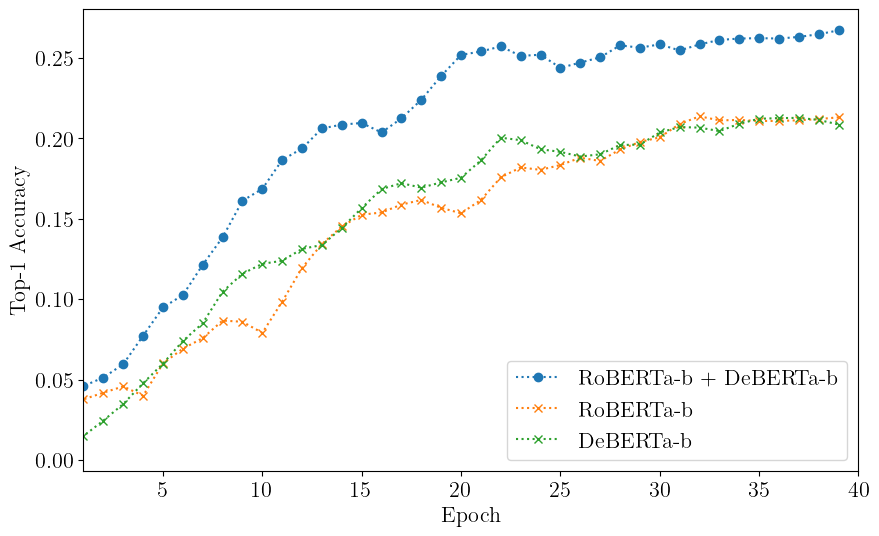

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = True

# Process the data (select columns)
epochs = df['Step']
u3c3 = savgol_filter(df['cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2 = savgol_filter(df['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u1c1 = savgol_filter(df['cnn_deberta-base_u3_50_classes_most_seed42 - val_acc'], window_length=7, polyorder=2)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, u2c2, linestyle=':', marker='o', label='RoBERTa-b + DeBERTa-b')
plt.plot(epochs, u3c3, linestyle=':', marker='x', label='RoBERTa-b')
plt.plot(epochs, u1c1, linestyle=':', marker='x', label='DeBERTa-b')

# Customize the plot
# plt.title('Top-1 Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
plt.legend(fontsize=16)  # Increase legend font size
plt.xlim(left=1, right=40)

plt.legend(fontsize=16)
plt.grid(False)

plt.savefig('D:\\Triager X\\triagerX\\notebook\\openj9\\openj9-top-1.pdf', bbox_inches='tight', pad_inches=0)


# Show the plot
plt.show()

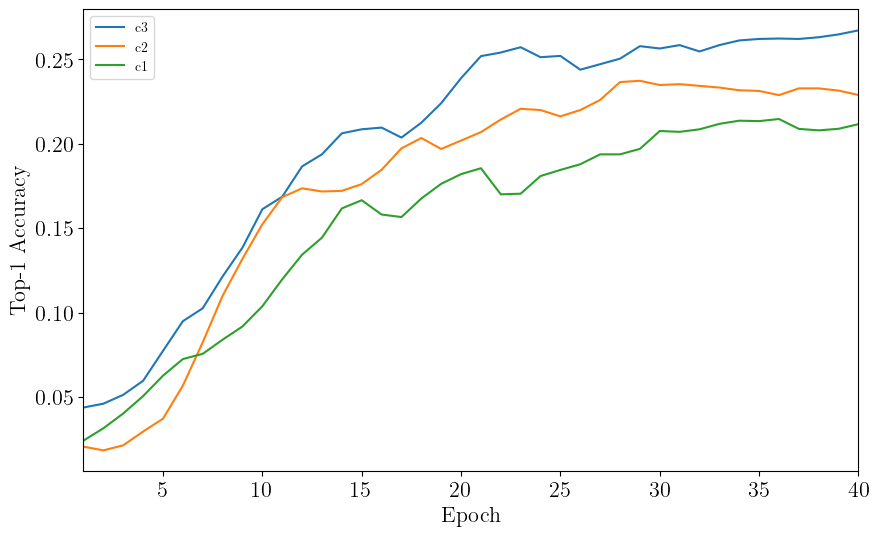

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = True

# Process the data (select columns)
epochs = df2['Step']
u3c3 = savgol_filter(df2['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2 = savgol_filter(df2['openj9_triagerx_ensemble_u2c2_50_classes_last_dev_seed42 - val_acc'] - 0.02, window_length=7, polyorder=2)
u1c1 = savgol_filter(df2['openj9_triagerx_ensemble_u3c1_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, u3c3, label='c3')
plt.plot(epochs, u2c2, label='c2')
plt.plot(epochs, u1c1, label='c1')

# Customize the plot
# plt.title('Top-1 Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Top-1 Accuracy', fontsize=16)
plt.xticks(fontsize=16)  # Increase x-axis tick font size
plt.yticks(fontsize=16)  # Increase y-axis tick font size
plt.legend(fontsize=16)  # Increase legend font size
plt.xlim(left=1, right=40)

plt.legend()
plt.grid(False)

plt.savefig('D:\\Triager X\\triagerX\\notebook\\openj9\\openj9-c1-c3.pdf', bbox_inches='tight', pad_inches=0)


# Show the plot
plt.show()

In [4]:
import requests
import json

# API endpoint
url = 'https://bugs.chromium.org/prpc/monorail.Issues/List'

# Headers
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'X-Prpc-Grpc-Code': 'true',
}

# Payload (adjust the query as needed)
payload = {
    'projectNames': ['chromium'],
    'query': 'status:Open',  # Example query to fetch open issues
    'pagination': {
        'maxResults': 10,  # Number of results per page
        'start': 0  # Starting index
    }
}

# Convert payload to JSON
data = json.dumps(payload)

# Send POST request
response = requests.post(url, headers=headers, data=data)

print(response)
# Check if request was successful
if response.status_code == 200:
    # Parse the JSON response
    issues = response.json()
    # Print the issues
    print(json.dumps(issues, indent=2))
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Process and display the results
if 'issues' in issues:
    for issue in issues['issues']:
        print(f"Issue ID: {issue['issueId']}")
        print(f"Summary: {issue['summary']}")
        print(f"Status: {issue['status']}")
        print('---')


<Response [501]>
Failed to retrieve data. Status code: 501


NameError: name 'issues' is not defined

In [3]:
import requests
import json

# API endpoint
url = 'https://bugs.chromium.org/prpc/monorail.Issues/ListIssues'

# Headers
headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Origin': 'https://bugs.chromium.org',
}

# Payload (adjust the query as needed)
payload = {
    'projectId': 'chromium',
    'query': 'status:Unresolved',  # Example query to fetch unresolved issues
    'pagination': {
        'pageSize': 10,  # Number of results per page
        'pageToken': ''  # Starting token
    }
}

# Convert payload to JSON
data = json.dumps(payload)

# Send POST request
response = requests.post(url, headers=headers, data=data)

# Check if request was successful
if response.status_code == 200:
    # Parse the JSON response
    issues = response.json()
    # Print the issues
    print(json.dumps(issues, indent=2))
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Process and display the results
if 'issues' in issues:
    for issue in issues['issues']:
        print(f"Issue ID: {issue['issueId']}")
        print(f"Summary: {issue['summary']}")
        print(f"Status: {issue['status']}")
        print('---')


Failed to retrieve data. Status code: 403


NameError: name 'issues' is not defined

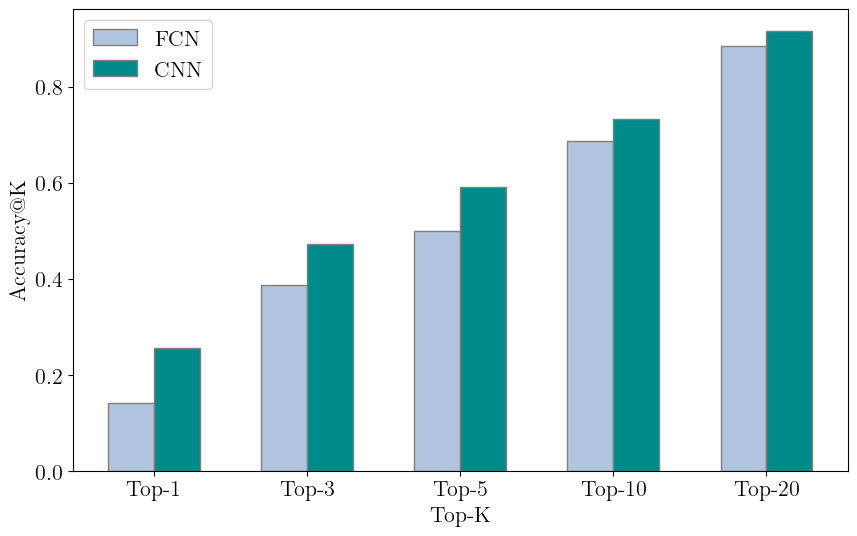

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = True


# Data
methods = ['Top-1', 'Top-3', 'Top-5', 'Top-10', 'Top-20']
fcn_accuracies = [0.143, 0.387, 0.5, 0.688, 0.884]
cnn_accuracies = [0.256, 0.472, 0.591, 0.733, 0.915]

# Bar width
bar_width = 0.15

# Positions of the bars on the x-axis with reduced space between groups
r1 = np.arange(len(methods)) * 0.5
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(r1, fcn_accuracies, color='lightsteelblue', width=bar_width, edgecolor='grey', label='FCN')
plt.bar(r2, cnn_accuracies, color='darkcyan', width=bar_width, edgecolor='grey', label='CNN')

# Adding labels and title
plt.xlabel('Top-K', fontweight='bold', fontsize=16)
plt.ylabel('Accuracy@K', fontweight='bold', fontsize=16)
# plt.title('Comparison of Top-k Accuracy: CNN vs. FCN', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in r1], methods, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.savefig('D:\\Triager X\\triagerX\\notebook\\openj9\\cnn-vs-fcn.pdf', bbox_inches='tight', pad_inches=0)
# Show plot
plt.show()


In [69]:
import numpy as np


np.linspace(0, 1, num=200).tolist()

[0.0,
 0.005025125628140704,
 0.010050251256281407,
 0.01507537688442211,
 0.020100502512562814,
 0.02512562814070352,
 0.03015075376884422,
 0.035175879396984924,
 0.04020100502512563,
 0.04522613065326633,
 0.05025125628140704,
 0.05527638190954774,
 0.06030150753768844,
 0.06532663316582915,
 0.07035175879396985,
 0.07537688442211056,
 0.08040201005025126,
 0.08542713567839195,
 0.09045226130653267,
 0.09547738693467336,
 0.10050251256281408,
 0.10552763819095477,
 0.11055276381909548,
 0.11557788944723618,
 0.12060301507537688,
 0.12562814070351758,
 0.1306532663316583,
 0.135678391959799,
 0.1407035175879397,
 0.1457286432160804,
 0.15075376884422112,
 0.15577889447236182,
 0.16080402010050251,
 0.1658291457286432,
 0.1708542713567839,
 0.17587939698492464,
 0.18090452261306533,
 0.18592964824120603,
 0.19095477386934673,
 0.19597989949748745,
 0.20100502512562815,
 0.20603015075376885,
 0.21105527638190955,
 0.21608040201005024,
 0.22110552763819097,
 0.22613065326633167,
 0.2311

In [75]:
def min_max_normalize(array):
    normalized_array = (array - np.min(array)) / (np.max(array) - np.min(array))
    return normalized_array

In [83]:
x = np.array([0.143, 0.387, 0.5, 0.688, 0.884])
min_max_normalize(np.exp(x * -1))

array([1.        , 0.58630552, 0.42634935, 0.19719535, 0.        ])

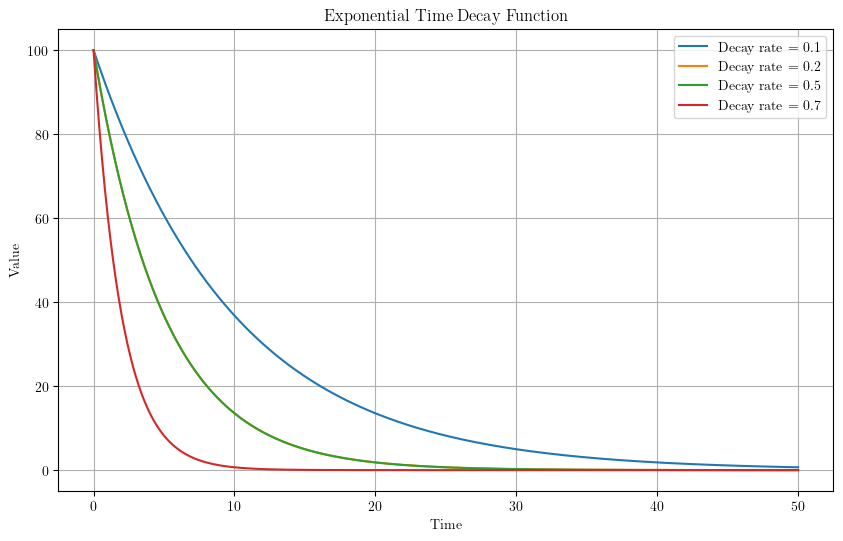

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def plot_exponential_decay(initial_value, decay_rate, time_period):
    """
    Plots an exponential time decay function.
    
    Parameters:
    initial_value (float): The initial value at time t=0.
    decay_rate (float): The rate at which the value decays over time.
    time_period (int): The period over which to plot the decay (number of time units).
    """
    
    # Generate time values
    time_values = np.linspace(0, time_period, 500)
    
    # Calculate exponential decay values
    decay_values = initial_value * np.exp(-decay_rate * time_values)
    decay_values2 = initial_value * np.exp(-0.2 * time_values)
    decay_values3 = initial_value * np.exp(-0.5 * time_values)
    decay_values4 = initial_value * np.exp(-0.7 * time_values)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, decay_values, label=f'Decay rate = {decay_rate}')
    plt.plot(time_values, decay_values2, label=f'Decay rate = {0.2}')
    plt.plot(time_values, decay_values2, label=f'Decay rate = {0.5}')
    plt.plot(time_values, decay_values3, label=f'Decay rate = {0.7}')
    plt.title('Exponential Time Decay Function')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_exponential_decay(initial_value=100, decay_rate=0.1, time_period=50)


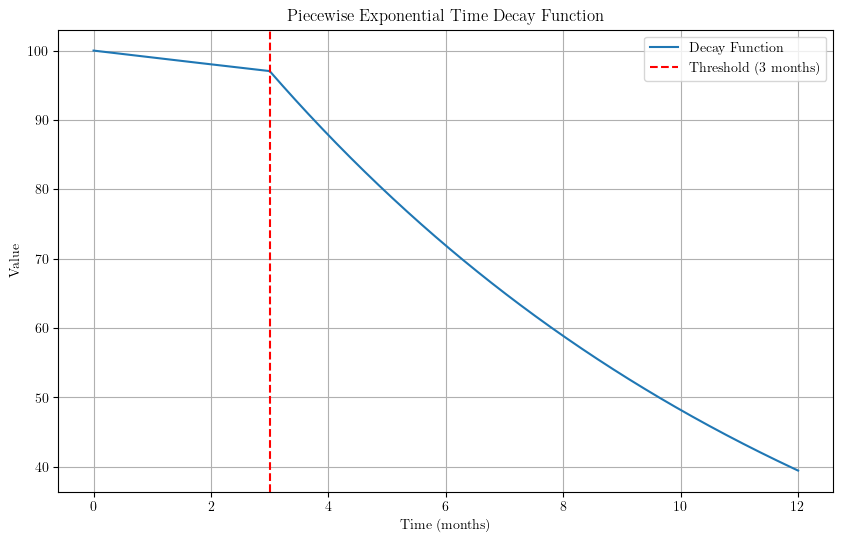

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

def months_since(date):
    current_date = datetime.now()
    difference = relativedelta(current_date, date)
    return difference.years * 12 + difference.months

def piecewise_decay_function(time, initial_value, slow_decay_rate, fast_decay_rate, threshold_months):
    decay_values = np.piecewise(
        time,
        [time <= threshold_months, time > threshold_months],
        [
            lambda t: initial_value * np.exp(-slow_decay_rate * t),
            lambda t: initial_value * np.exp(-slow_decay_rate * threshold_months) * np.exp(-fast_decay_rate * (t - threshold_months)),
        ]
    )
    return decay_values

def plot_piecewise_decay(initial_value, slow_decay_rate, fast_decay_rate, time_period, threshold_months):
    # Generate time values in months
    time_values = np.linspace(0, time_period, 500)
    
    # Calculate decay values using the piecewise decay function
    decay_values = piecewise_decay_function(time_values, initial_value, slow_decay_rate, fast_decay_rate, threshold_months)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, decay_values, label='Decay Function')
    plt.title('Piecewise Exponential Time Decay Function')
    plt.xlabel('Time (months)')
    plt.ylabel('Value')
    plt.axvline(x=threshold_months, color='r', linestyle='--', label='Threshold (3 months)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
initial_value = 100
slow_decay_rate = 0.01  # Slow decay rate within 3 months
fast_decay_rate = 0.1   # Fast decay rate after 3 months
time_period = 12        # Time period to plot (in months)
threshold_months = 3   # Threshold for switching decay rate (in months)

plot_piecewise_decay(initial_value, slow_decay_rate, fast_decay_rate, time_period, threshold_months)


In [143]:
time_factor_df = pd.read_csv("time_factor.csv")

In [144]:
time_factor_df = time_factor_df.sort_values(by="time_decay_factor", ascending=True)

In [145]:
time_factor_df

,similarity_prediction_weight,time_decay_factor,direct_assignment_score,contribution_score,discussion_score,similarity_threshold,topk_issues,T1DL,T1Sim,T1Com,...,T3Com,T5DL,T5Sim,T5Com,T10DL,T10Sim,T10Com,T20DL,T20Sim,T20Com
19,0.65,-0.10,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.110818,...,0.416887,0.591029,0.263852,0.556728,0.728232,0.514512,0.722955,0.899736,0.804749,0.889182
18,0.65,-0.09,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.110818,...,0.416887,0.591029,0.263852,0.556728,0.728232,0.517150,0.720317,0.899736,0.804749,0.889182
17,0.65,-0.08,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.110818,...,0.414248,0.591029,0.263852,0.554090,0.728232,0.519789,0.720317,0.899736,0.804749,0.889182
16,0.65,-0.07,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.110818,...,0.414248,0.591029,0.263852,0.554090,0.728232,0.517150,0.717678,0.899736,0.804749,0.889182
15,0.65,-0.06,0.5,1.5,0.2,0.5,20,0.255937,0.073879,0.113456,...,0.411609,0.591029,0.266491,0.556728,0.728232,0.519789,0.717678,0.899736,0.804749,0.889182
14,0.65,-0.05,0.5,1.5,0.2,0.5,20,0.255937,0.079156,0.113456,...,0.408971,0.591029,0.266491,0.562005,0.728232,0.519789,0.717678,0.899736,0.804749,0.889182
13,0.65,-0.04,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.108179,...,0.416887,0.591029,0.269129,0.562005,0.728232,0.525066,0.715040,0.899736,0.804749,0.889182
12,0.65,-0.03,0.5,1.5,0.2,0.5,20,0.255937,0.076517,0.113456,...,0.419525,0.591029,0.269129,0.556728,0.728232,0.527704,0.712401,0.899736,0.804749,0.889182
11,0.65,-0.02,0.5,1.5,0.2,0.5,20,0.255937,0.081794,0.116095,...,0.416887,0.591029,0.269129,0.551451,0.728232,0.530343,0.704485,0.899736,0.804749,0.886544
20,0.65,-0.01,0.5,1.5,0.2,0.5,20,0.255937,0.089710,0.129288,...,0.424802,0.591029,0.274406,0.551451,0.728232,0.530343,0.701847,0.899736,0.807388,0.886544


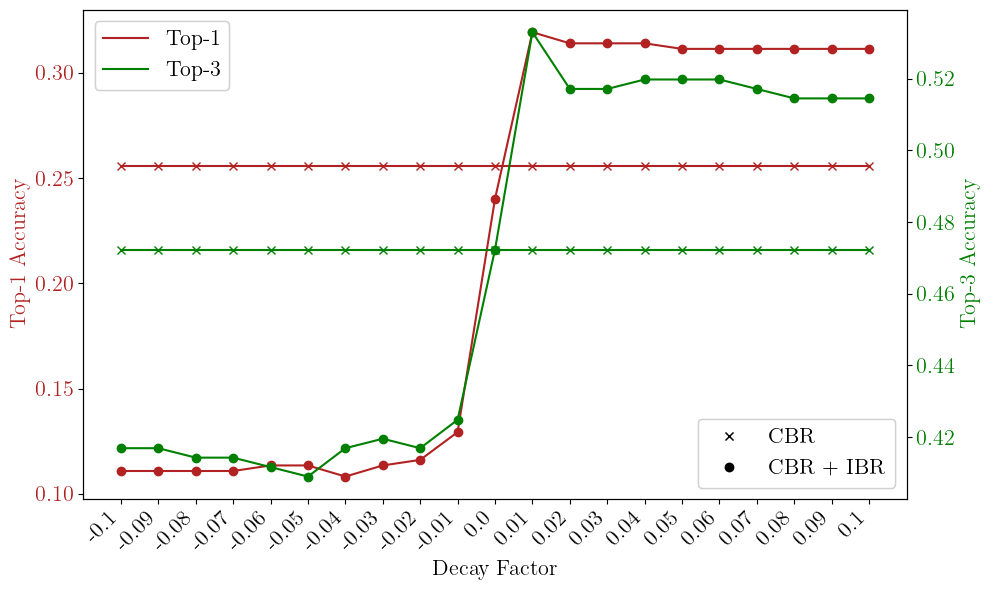

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = True

# Process the data (select columns)
time_factor = time_factor_df['time_decay_factor'].tolist()
t1dl = time_factor_df["T1DL"].tolist()
t1 = time_factor_df["T1Com"].tolist()
t3dl = time_factor_df["T3DL"].tolist()
t3 = time_factor_df["T3Com"].tolist()

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Top-1 accuracy on primary y-axis with different markers
ax1.plot(time_factor, t1, color='firebrick', marker='o')
ax1.plot(time_factor, t1dl, color='firebrick', marker='x')
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.set_ylabel('Top-1 Accuracy', fontsize=16, color='firebrick')
ax1.tick_params(axis='y', labelcolor='firebrick')

# Create a secondary y-axis for Top-3 accuracy with different markers
ax2 = ax1.twinx()
ax2.plot(time_factor, t3, color='green', marker='o')
ax2.plot(time_factor, t3dl, color='green', marker='x')
ax2.set_ylabel('Top-3 Accuracy', fontsize=16, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Customize the plot
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Set x-axis tick positions and labels
ax1.set_xticks(time_factor)
ax1.set_xticklabels([str(tf) for tf in time_factor], rotation=45, ha='right')

# Create proxy artists for the legends
top1_line = mlines.Line2D([], [], color='firebrick', label='Top-1')
top3_line = mlines.Line2D([], [], color='green', label='Top-3')
cbr_line = mlines.Line2D([], [], color='black', marker='x', linestyle='None', label='CBR')
cbr_cob_line = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='CBR + IBR')

# Create legends for each set of markers separately
legend1 = ax1.legend(handles=[top1_line, top3_line], loc='upper left', fontsize=16)
legend2 = ax2.legend(handles=[cbr_line, cbr_cob_line], loc='lower right', fontsize=16)

# Add the legends to the plot
ax1.add_artist(legend1)
ax2.add_artist(legend2)

# Adjust layout and save/show the plot
plt.tight_layout()
plt.savefig('D:\\Triager X\\triagerX\\notebook\\openj9\\openj9-decay-factor.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [218]:
gg = "35 25  8  9 17  8 30 30  9  8 31 10 17  8  8 20 15  8  9 27 15 30 18 25 10 30 35 33 35 27 21 46  8 41  8  8 32  8 10 10  2 21 22 18 40 17  8  2 19 31 38 15  8 22  5 28 13  2 21 30 30 15 31 30 41 39 48 25 24 44 40 47 35 19 19 19  8 31 45 41 39  8  8 21 18 34  8  8 31  9 45 45 34  4 30  8 12  6 27 41 49 18 44 29 21 17 20 18 30 42  8 28 25 21  8 19 32  8 12 45 39  8 15 23 21 22 31  8 45 10 45  9 35 21 21 22 47 30 44  8 31 45  9 31 48 31 19 36 35 13  9 35 35 35 31 32 30 46 31 10 44 45 44  5 17 31 20 13 45  8 25 23 29 35 30 30 18 31 15 40  8  9 31 17 18  8 21 15 19 19  8 39 8  8  8 19 47  8 30  9 27 25  8 31  8 45 11 46 46 21  9 10 39  8  8 44 44 25  0 35  9  9 19 19 19 19  8 31 19 31 23 25 19 35 11 30 25 17 30 49 31 39 40 40 39 27 10 19 30 19 10 44 10 10 10 10 13 15 40 35 35 39 31 44 11 25 45 10 31 38 25 25  9  9 30 27 48 21 17 28 49 21 35 25 31 11 46 13 45 17 49 20 35  9  9  9 25  9  9 43  2 15 45 45 27  9 31 40 35 17 35 35 35 23  8 35 27 30 12  9 25 31  4 21 35  8 19 27 37 20 39 31 31 31 21  9 30 15 23 42 30  9 40 39 19 22 22 25 29 36 30 24 31 49  9 45 30 28  8  5 28  9 23 11  7 30 14 35 31 45 22 49 30  8 38 28 22 21 10  8 30 30"

In [219]:
gg = [int(x.strip()) for x in gg.split()]

In [264]:
gg

[35,
 25,
 8,
 9,
 17,
 8,
 30,
 30,
 9,
 8,
 31,
 10,
 17,
 8,
 8,
 20,
 15,
 8,
 9,
 27,
 15,
 30,
 18,
 25,
 10,
 30,
 35,
 33,
 35,
 27,
 21,
 46,
 8,
 41,
 8,
 8,
 32,
 8,
 10,
 10,
 2,
 21,
 22,
 18,
 40,
 17,
 8,
 2,
 19,
 31,
 38,
 15,
 8,
 22,
 5,
 28,
 13,
 2,
 21,
 30,
 30,
 15,
 31,
 30,
 41,
 39,
 48,
 25,
 24,
 44,
 40,
 47,
 35,
 19,
 19,
 19,
 8,
 31,
 45,
 41,
 39,
 8,
 8,
 21,
 18,
 34,
 8,
 8,
 31,
 9,
 45,
 45,
 34,
 4,
 30,
 8,
 12,
 6,
 27,
 41,
 49,
 18,
 44,
 29,
 21,
 17,
 20,
 18,
 30,
 42,
 8,
 28,
 25,
 21,
 8,
 19,
 32,
 8,
 12,
 45,
 39,
 8,
 15,
 23,
 21,
 22,
 31,
 8,
 45,
 10,
 45,
 9,
 35,
 21,
 21,
 22,
 47,
 30,
 44,
 8,
 31,
 45,
 9,
 31,
 48,
 31,
 19,
 36,
 35,
 13,
 9,
 35,
 35,
 35,
 31,
 32,
 30,
 46,
 31,
 10,
 44,
 45,
 44,
 5,
 17,
 31,
 20,
 13,
 45,
 8,
 25,
 23,
 29,
 35,
 30,
 30,
 18,
 31,
 15,
 40,
 8,
 9,
 31,
 17,
 18,
 8,
 21,
 15,
 19,
 19,
 8,
 39,
 8,
 8,
 8,
 19,
 47,
 8,
 30,
 9,
 27,
 25,
 8,
 31,
 8,
 45,
 11,
 46,
 46,
 21,


In [223]:
yy = "17  2 17 27 17  2 30 27 32 27  8  8 27  8  8 47 38  8 27 27 39  2 21 29 8 30 17 39 25  8 27 19  8 29  8  8  8  8 10 10  8 17 10 29 27 27 45 17 8 31 38  8  8 29  2  4 17  2  2 30 41  8 25 30 30  8 30  9 45 19  8 35 14 19  8 19  8  5 27 30 41 30 25 21  8 41 19 25 30 25 27 27 34  8 30 27 21 21 25 41 25 30 39  8 47  8 27  8 30  5  5 30 27 30  8 25 38 14 30  7 27 30  8 47 21 25 27 30 31 27 19  8 27 25 46 32  8 27  8 19  4 30 19 27 30 27  8 27 31 27 34  5  8  8 30 27 30 19  5 10 41 27 11  8 27 31 25 27 27 34  2 27  2 41 31 41  8  1 11 46  8 14 31 11 30 19 27 31 30  8 19 19 8  8  8  8  8 27 22 47 30  2 41 27  8 27 11  8 19  2  2  8  9 30  8 30 41  2 30 27  9 29 41 41  8 27  8 34  8 27 47  9 41 27 11 19  5 17 31 38 2 42 34 41 39 41 47 19 41 25 10 10 10 10 10 10 17 11 19 41 45 25 27 27 11 23 25 10 45 30 25 25 39 23 30 17 30  8 27 30 45  9 22  2 27  2 19 17 17 34 41 47 35 39 10 47  9 47 39 27 25 38 29 29  8 27 44 27 34 42 39 25 34 47  8 27 27 30 30  2  2 31 34 32 41 41  9 30 41 41  8  8 41  8 23 34 27 11 23  2 30 41 27 44  8 27  8 41 42  9 47 11 30  9 30 32 42 34  8 45 41 31 47 11 32 41 14 30 31 11 49 31 34 34 29 27 41 39 30 27 34 41"

In [224]:
yy = [int(x.strip()) for x in yy.split()]

In [228]:
import numpy as np

In [235]:
true = np.bincount(yy)

In [240]:
correct_truths = {idx: occurance for idx, occurance in enumerate(true) if occurance != 0}

In [244]:
gg

[35,
 25,
 8,
 9,
 17,
 8,
 30,
 30,
 9,
 8,
 31,
 10,
 17,
 8,
 8,
 20,
 15,
 8,
 9,
 27,
 15,
 30,
 18,
 25,
 10,
 30,
 35,
 33,
 35,
 27,
 21,
 46,
 8,
 41,
 8,
 8,
 32,
 8,
 10,
 10,
 2,
 21,
 22,
 18,
 40,
 17,
 8,
 2,
 19,
 31,
 38,
 15,
 8,
 22,
 5,
 28,
 13,
 2,
 21,
 30,
 30,
 15,
 31,
 30,
 41,
 39,
 48,
 25,
 24,
 44,
 40,
 47,
 35,
 19,
 19,
 19,
 8,
 31,
 45,
 41,
 39,
 8,
 8,
 21,
 18,
 34,
 8,
 8,
 31,
 9,
 45,
 45,
 34,
 4,
 30,
 8,
 12,
 6,
 27,
 41,
 49,
 18,
 44,
 29,
 21,
 17,
 20,
 18,
 30,
 42,
 8,
 28,
 25,
 21,
 8,
 19,
 32,
 8,
 12,
 45,
 39,
 8,
 15,
 23,
 21,
 22,
 31,
 8,
 45,
 10,
 45,
 9,
 35,
 21,
 21,
 22,
 47,
 30,
 44,
 8,
 31,
 45,
 9,
 31,
 48,
 31,
 19,
 36,
 35,
 13,
 9,
 35,
 35,
 35,
 31,
 32,
 30,
 46,
 31,
 10,
 44,
 45,
 44,
 5,
 17,
 31,
 20,
 13,
 45,
 8,
 25,
 23,
 29,
 35,
 30,
 30,
 18,
 31,
 15,
 40,
 8,
 9,
 31,
 17,
 18,
 8,
 21,
 15,
 19,
 19,
 8,
 39,
 8,
 8,
 8,
 19,
 47,
 8,
 30,
 9,
 27,
 25,
 8,
 31,
 8,
 45,
 11,
 46,
 46,
 21,


In [241]:
correct_truths

{1: 1,
 2: 18,
 4: 2,
 5: 6,
 7: 1,
 8: 59,
 9: 9,
 10: 12,
 11: 11,
 14: 4,
 17: 12,
 19: 17,
 21: 5,
 22: 2,
 23: 4,
 25: 18,
 27: 52,
 29: 8,
 30: 39,
 31: 12,
 32: 5,
 34: 14,
 35: 2,
 38: 5,
 39: 9,
 41: 28,
 42: 4,
 44: 2,
 45: 6,
 46: 2,
 47: 12,
 49: 1}

In [242]:
preds = {idx: occurance for idx, occurance in enumerate(np.bincount(gg)) if occurance != 0}

In [243]:
preds

{0: 1,
 2: 4,
 4: 2,
 5: 3,
 6: 1,
 7: 1,
 8: 42,
 9: 25,
 10: 15,
 11: 5,
 12: 3,
 13: 5,
 14: 1,
 15: 10,
 17: 10,
 18: 7,
 19: 19,
 20: 5,
 21: 16,
 22: 8,
 23: 6,
 24: 2,
 25: 16,
 27: 9,
 28: 6,
 29: 3,
 30: 27,
 31: 28,
 32: 3,
 33: 1,
 34: 2,
 35: 23,
 36: 2,
 37: 1,
 38: 3,
 39: 10,
 40: 8,
 41: 4,
 42: 2,
 43: 1,
 44: 9,
 45: 16,
 46: 5,
 47: 3,
 48: 3,
 49: 6}

In [320]:
triagerx_pred = [35, 25, 8, 9, 17, 8, 30, 30, 41, 27, 31, 10, 17, 8, 8, 30, 15, 8, 9, 27, 38, 30, 8, 25, 10, 30, 27, 25, 45, 8, 30, 21, 8, 41, 8, 8, 8, 8, 10, 10, 2, 17, 10, 29, 40, 27, 27, 2, 19, 31, 38, 15, 8, 22, 31, 4, 38, 2, 25, 30, 30, 15, 35, 30, 23, 8, 27, 25, 38, 44, 27, 27, 41, 27, 19, 19, 8, 31, 8, 27, 35, 27, 27, 21, 8, 41, 8, 8, 31, 9, 45, 45, 41, 4, 30, 8, 30, 20, 27, 41, 49, 40, 8, 25, 3, 2, 45, 8, 30, 36, 8, 4, 41, 30, 8, 19, 37, 8, 45, 45, 8, 8, 38, 23, 19, 41, 10, 30, 30, 8, 8, 9, 45, 25, 8, 10, 27, 27, 44, 8, 31, 45, 19, 27, 27, 31, 19, 34, 27, 32, 8, 8, 35, 35, 27, 41, 30, 8, 31, 10, 44, 45, 44, 8, 17, 31, 20, 8, 27, 8, 25, 23, 29, 27, 30, 30, 32, 31, 15, 40, 8, 32, 31, 27, 8, 8, 21, 15, 19, 8, 8, 39, 8, 8, 8, 8, 8, 41, 41, 21, 27, 41, 8, 30, 8, 8, 2, 46, 8, 23, 2, 10, 29, 8, 8, 44, 19, 25, 20, 35, 9, 9, 19, 19, 19, 8, 8, 19, 8, 5, 23, 25, 27, 27, 11, 30, 25, 17, 8, 49, 31, 13, 27, 41, 25, 27, 19, 8, 41, 19, 41, 41, 10, 10, 10, 10, 49, 38, 40, 34, 35, 29, 31, 41, 11, 23, 17, 10, 27, 30, 25, 25, 9, 9, 30, 27, 37, 8, 27, 30, 17, 24, 35, 25, 35, 11, 30, 49, 45, 41, 8, 21, 35, 9, 9, 9, 25, 9, 9, 23, 25, 38, 38, 41, 27, 9, 31, 40, 41, 27, 41, 9, 35, 21, 8, 35, 27, 30, 30, 25, 25, 31, 4, 21, 8, 8, 19, 27, 37, 41, 41, 41, 41, 41, 30, 41, 30, 29, 23, 42, 30, 37, 40, 41, 19, 22, 19, 29, 9, 49, 23, 38, 30, 49, 30, 45, 30, 30, 8, 39, 41, 31, 23, 38, 7, 41, 14, 27, 31, 34, 22, 49, 41, 27, 38, 27, 20, 21, 10, 8, 4, 34]

In [321]:
deberta_pred = [35, 38, 8, 9, 15, 8, 30, 30, 9, 37, 44, 10, 17, 8, 8, 30, 15, 8, 9, 27, 15, 27, 46, 49, 10, 30, 35, 17, 35, 8, 21, 46, 8, 8, 8, 8, 44, 8, 10, 10, 2, 13, 10, 29, 47, 17, 44, 2, 19, 31, 38, 15, 8, 22, 31, 28, 17, 48, 20, 30, 49, 38, 35, 43, 43, 39, 30, 20, 38, 44, 40, 40, 17, 44, 44, 44, 8, 31, 45, 39, 35, 21, 8, 23, 29, 34, 8, 9, 8, 9, 45, 45, 30, 4, 30, 36, 12, 6, 8, 41, 49, 40, 19, 36, 23, 23, 12, 8, 30, 36, 35, 28, 49, 48, 8, 39, 36, 8, 12, 45, 39, 8, 15, 23, 18, 49, 31, 41, 9, 10, 9, 9, 35, 20, 8, 22, 27, 30, 44, 21, 31, 45, 9, 27, 48, 31, 19, 36, 35, 36, 35, 35, 35, 35, 31, 9, 16, 8, 31, 10, 44, 35, 44, 8, 17, 31, 20, 8, 17, 8, 25, 27, 29, 35, 31, 30, 29, 31, 15, 40, 8, 32, 31, 17, 8, 19, 0, 15, 19, 8, 8, 8, 8, 8, 8, 19, 19, 41, 41, 9, 16, 13, 8, 31, 8, 26, 2, 8, 8, 23, 9, 10, 27, 8, 8, 44, 19, 25, 20, 35, 9, 9, 8, 10, 44, 44, 8, 8, 8, 41, 23, 9, 34, 35, 15, 30, 25, 17, 8, 49, 5, 39, 44, 40, 19, 27, 10, 8, 41, 19, 8, 19, 10, 10, 10, 10, 49, 38, 40, 35, 35, 49, 31, 40, 11, 23, 17, 10, 17, 48, 25, 25, 9, 9, 41, 17, 37, 8, 30, 28, 17, 24, 35, 25, 35, 11, 23, 49, 28, 17, 8, 26, 35, 9, 9, 9, 25, 9, 9, 23, 25, 15, 14, 14, 17, 9, 31, 40, 35, 17, 9, 35, 35, 21, 8, 35, 27, 30, 20, 25, 25, 31, 4, 7, 9, 27, 19, 27, 20, 41, 39, 27, 27, 8, 14, 41, 21, 15, 23, 49, 16, 9, 40, 39, 10, 22, 32, 29, 9, 49, 38, 38, 27, 49, 9, 18, 16, 30, 9, 39, 28, 35, 34, 38, 7, 41, 14, 35, 31, 14, 45, 49, 30, 40, 38, 40, 22, 38, 10, 8, 30, 30]

In [322]:
roberta_pred = gg

In [323]:
correct_pred = [17, 2, 17, 27, 17, 2, 30, 27, 32, 27, 8, 8, 27, 8, 8, 47, 38, 8, 27, 27, 39, 2, 21, 29, 8, 30, 17, 39, 25, 8, 27, 19, 8, 29, 8, 8, 8, 8, 10, 10, 8, 17, 10, 29, 27, 27, 45, 17, 8, 31, 38, 8, 8, 29, 2, 4, 17, 2, 2, 30, 41, 8, 25, 30, 30, 8, 30, 9, 45, 19, 8, 35, 14, 19, 8, 19, 8, 5, 27, 30, 41, 30, 25, 21, 8, 41, 19, 25, 30, 25, 27, 27, 34, 8, 30, 27, 21, 21, 25, 41, 25, 30, 39, 8, 47, 8, 27, 8, 30, 5, 5, 30, 27, 30, 8, 25, 38, 14, 30, 7, 27, 30, 8, 47, 21, 25, 27, 30, 31, 27, 19, 8, 27, 25, 46, 32, 8, 27, 8, 19, 4, 30, 19, 27, 30, 27, 8, 27, 31, 27, 34, 5, 8, 8, 30, 27, 30, 19, 5, 10, 41, 27, 11, 8, 27, 31, 25, 27, 27, 34, 2, 27, 2, 41, 31, 41, 8, 1, 11, 46, 8, 14, 31, 11, 30, 19, 27, 31, 30, 8, 19, 19, 8, 8, 8, 8, 8, 27, 22, 47, 30, 2, 41, 27, 8, 27, 11, 8, 19, 2, 2, 8, 9, 30, 8, 30, 41, 2, 30, 27, 9, 29, 41, 41, 8, 27, 8, 34, 8, 27, 47, 9, 41, 27, 11, 19, 5, 17, 31, 38, 2, 42, 34, 41, 39, 41, 47, 19, 41, 25, 10, 10, 10, 10, 10, 10, 17, 11, 19, 41, 45, 25, 27, 27, 11, 23, 25, 10, 45, 30, 25, 25, 39, 23, 30, 17, 30, 8, 27, 30, 45, 9, 22, 2, 27, 2, 19, 17, 17, 34, 41, 47, 35, 39, 10, 47, 9, 47, 39, 27, 25, 38, 29, 29, 8, 27, 44, 27, 34, 42, 39, 25, 34, 47, 8, 27, 27, 30, 30, 2, 2, 31, 34, 32, 41, 41, 9, 30, 41, 41, 8, 8, 41, 8, 23, 34, 27, 11, 23, 2, 30, 41, 27, 44, 8, 27, 8, 41, 42, 9, 47, 11, 30, 9, 30, 32, 42, 34, 8, 45, 41, 31, 47, 11, 32, 41, 14, 30, 31, 11, 49, 31, 34, 34, 29, 27, 41, 39, 30, 27, 34, 41]

In [409]:
index = [idx for idx, target in enumerate(correct_pred) if target in [2, 8, 10, 15, 20, 25, 30, 35, 40, 23, 27, 30, 41, 38]]

In [412]:
class_comparison_data = {
    "y_true": correct_pred,
    "roberta_pred": roberta_pred,
    "deberta_pred": deberta_pred,
    "triagerx_cbr": triagerx_pred
}

In [417]:
import json
with open("top1_class_comparison.json", "w") as f:
    json.dump(class_comparison_data, f, indent=2)

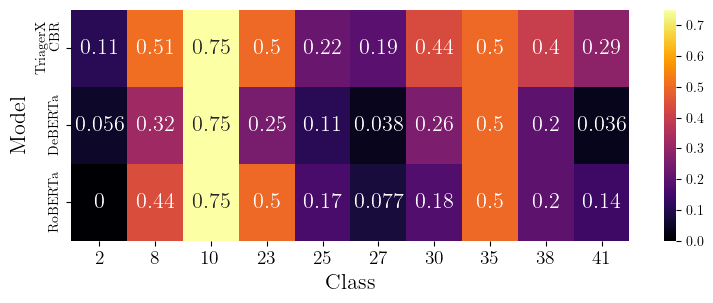

In [411]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example true labels and predictions for three models
y_true = np.array(correct_pred)[index]
y_pred_model1 = np.array(triagerx_pred)[index]
y_pred_model2 = np.array(roberta_pred)[index]
y_pred_model3 = np.array(deberta_pred)[index]

# Unique classes
classes = np.unique(y_true)

# Calculate correct predictions for each model and each class
def count_correct_predictions(y_true, y_pred, classes):
    correct_counts = []
    for cls in classes:
        correct_counts.append(np.sum((y_true == cls) & (y_true == y_pred)))
    return correct_counts

correct_model1 = count_correct_predictions(y_true, y_pred_model1, classes)
correct_model2 = count_correct_predictions(y_true, y_pred_model2, classes)
correct_model3 = count_correct_predictions(y_true, y_pred_model3, classes)

# Calculate total correct truths for each class
total_correct = np.array([np.sum(y_true == cls) for cls in classes])

# Normalize correct predictions by total correct truths for each class
normalized_correct_model1 = np.array(correct_model1) / total_correct
normalized_correct_model2 = np.array(correct_model2) / total_correct
normalized_correct_model3 = np.array(correct_model3) / total_correct

# Combine the normalized correct predictions into a single array for heatmap
normalized_correct_predictions = np.array([normalized_correct_model1, normalized_correct_model2, normalized_correct_model3])

# Create a heatmap
plt.figure(figsize=(9, 3))
ax = sns.heatmap(normalized_correct_predictions, annot=True, cmap='inferno', xticklabels=classes, yticklabels=['TriagerX\nCBR', 'DeBERTa', 'RoBERTa'], annot_kws={"size": 16})
# plt.title('Class-wise comparison of top-1 accuracy on Openj9 dataset.', f)
plt.xlabel('Class', fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=16)
# ax.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Model', fontsize=16)
plt.savefig('D:\\Triager X\\triagerX\\notebook\\openj9\\openj9-top1-classwise.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [309]:
{"pred": [35, 38, 8, 9, 15, 8, 30, 30, 9, 37, 44, 10, 17, 8, 8, 30, 15, 8, 9, 27, 15, 27, 46, 49, 10, 30, 35, 17, 35, 8, 21, 46, 8, 8, 8, 8, 44, 8, 10, 10, 2, 13, 10, 29, 47, 17, 44, 2, 19, 31, 38, 15, 8, 22, 31, 28, 17, 48, 20, 30, 49, 38, 35, 43, 43, 39, 30, 20, 38, 44, 40, 40, 17, 44, 44, 44, 8, 31, 45, 39, 35, 21, 8, 23, 29, 34, 8, 9, 8, 9, 45, 45, 30, 4, 30, 36, 12, 6, 8, 41, 49, 40, 19, 36, 23, 23, 12, 8, 30, 36, 35, 28, 49, 48, 8, 39, 36, 8, 12, 45, 39, 8, 15, 23, 18, 49, 31, 41, 9, 10, 9, 9, 35, 20, 8, 22, 27, 30, 44, 21, 31, 45, 9, 27, 48, 31, 19, 36, 35, 36, 35, 35, 35, 35, 31, 9, 16, 8, 31, 10, 44, 35, 44, 8, 17, 31, 20, 8, 17, 8, 25, 27, 29, 35, 31, 30, 29, 31, 15, 40, 8, 32, 31, 17, 8, 19, 0, 15, 19, 8, 8, 8, 8, 8, 8, 19, 19, 41, 41, 9, 16, 13, 8, 31, 8, 26, 2, 8, 8, 23, 9, 10, 27, 8, 8, 44, 19, 25, 20, 35, 9, 9, 8, 10, 44, 44, 8, 8, 8, 41, 23, 9, 34, 35, 15, 30, 25, 17, 8, 49, 5, 39, 44, 40, 19, 27, 10, 8, 41, 19, 8, 19, 10, 10, 10, 10, 49, 38, 40, 35, 35, 49, 31, 40, 11, 23, 17, 10, 17, 48, 25, 25, 9, 9, 41, 17, 37, 8, 30, 28, 17, 24, 35, 25, 35, 11, 23, 49, 28, 17, 8, 26, 35, 9, 9, 9, 25, 9, 9, 23, 25, 15, 14, 14, 17, 9, 31, 40, 35, 17, 9, 35, 35, 21, 8, 35, 27, 30, 20, 25, 25, 31, 4, 7, 9, 27, 19, 27, 20, 41, 39, 27, 27, 8, 14, 41, 21, 15, 23, 49, 16, 9, 40, 39, 10, 22, 32, 29, 9, 49, 38, 38, 27, 49, 9, 18, 16, 30, 9, 39, 28, 35, 34, 38, 7, 41, 14, 35, 31, 14, 45, 49, 30, 40, 38, 40, 22, 38, 10, 8, 30, 30], "true": [17, 2, 17, 27, 17, 2, 30, 27, 32, 27, 8, 8, 27, 8, 8, 47, 38, 8, 27, 27, 39, 2, 21, 29, 8, 30, 17, 39, 25, 8, 27, 19, 8, 29, 8, 8, 8, 8, 10, 10, 8, 17, 10, 29, 27, 27, 45, 17, 8, 31, 38, 8, 8, 29, 2, 4, 17, 2, 2, 30, 41, 8, 25, 30, 30, 8, 30, 9, 45, 19, 8, 35, 14, 19, 8, 19, 8, 5, 27, 30, 41, 30, 25, 21, 8, 41, 19, 25, 30, 25, 27, 27, 34, 8, 30, 27, 21, 21, 25, 41, 25, 30, 39, 8, 47, 8, 27, 8, 30, 5, 5, 30, 27, 30, 8, 25, 38, 14, 30, 7, 27, 30, 8, 47, 21, 25, 27, 30, 31, 27, 19, 8, 27, 25, 46, 32, 8, 27, 8, 19, 4, 30, 19, 27, 30, 27, 8, 27, 31, 27, 34, 5, 8, 8, 30, 27, 30, 19, 5, 10, 41, 27, 11, 8, 27, 31, 25, 27, 27, 34, 2, 27, 2, 41, 31, 41, 8, 1, 11, 46, 8, 14, 31, 11, 30, 19, 27, 31, 30, 8, 19, 19, 8, 8, 8, 8, 8, 27, 22, 47, 30, 2, 41, 27, 8, 27, 11, 8, 19, 2, 2, 8, 9, 30, 8, 30, 41, 2, 30, 27, 9, 29, 41, 41, 8, 27, 8, 34, 8, 27, 47, 9, 41, 27, 11, 19, 5, 17, 31, 38, 2, 42, 34, 41, 39, 41, 47, 19, 41, 25, 10, 10, 10, 10, 10, 10, 17, 11, 19, 41, 45, 25, 27, 27, 11, 23, 25, 10, 45, 30, 25, 25, 39, 23, 30, 17, 30, 8, 27, 30, 45, 9, 22, 2, 27, 2, 19, 17, 17, 34, 41, 47, 35, 39, 10, 47, 9, 47, 39, 27, 25, 38, 29, 29, 8, 27, 44, 27, 34, 42, 39, 25, 34, 47, 8, 27, 27, 30, 30, 2, 2, 31, 34, 32, 41, 41, 9, 30, 41, 41, 8, 8, 41, 8, 23, 34, 27, 11, 23, 2, 30, 41, 27, 44, 8, 27, 8, 41, 42, 9, 47, 11, 30, 9, 30, 32, 42, 34, 8, 45, 41, 31, 47, 11, 32, 41, 14, 30, 31, 11, 49, 31, 34, 34, 29, 27, 41, 39, 30, 27, 34, 41]}

{'pred': [35,
  38,
  8,
  9,
  15,
  8,
  30,
  30,
  9,
  37,
  44,
  10,
  17,
  8,
  8,
  30,
  15,
  8,
  9,
  27,
  15,
  27,
  46,
  49,
  10,
  30,
  35,
  17,
  35,
  8,
  21,
  46,
  8,
  8,
  8,
  8,
  44,
  8,
  10,
  10,
  2,
  13,
  10,
  29,
  47,
  17,
  44,
  2,
  19,
  31,
  38,
  15,
  8,
  22,
  31,
  28,
  17,
  48,
  20,
  30,
  49,
  38,
  35,
  43,
  43,
  39,
  30,
  20,
  38,
  44,
  40,
  40,
  17,
  44,
  44,
  44,
  8,
  31,
  45,
  39,
  35,
  21,
  8,
  23,
  29,
  34,
  8,
  9,
  8,
  9,
  45,
  45,
  30,
  4,
  30,
  36,
  12,
  6,
  8,
  41,
  49,
  40,
  19,
  36,
  23,
  23,
  12,
  8,
  30,
  36,
  35,
  28,
  49,
  48,
  8,
  39,
  36,
  8,
  12,
  45,
  39,
  8,
  15,
  23,
  18,
  49,
  31,
  41,
  9,
  10,
  9,
  9,
  35,
  20,
  8,
  22,
  27,
  30,
  44,
  21,
  31,
  45,
  9,
  27,
  48,
  31,
  19,
  36,
  35,
  36,
  35,
  35,
  35,
  35,
  31,
  9,
  16,
  8,
  31,
  10,
  44,
  35,
  44,
  8,
  17,
  31,
  20,
  8,
  17,
  8,
  25,
  27,


In [310]:
{"pred": [35, 25, 8, 9, 17, 8, 30, 30, 41, 27, 31, 10, 17, 8, 8, 30, 15, 8, 9, 27, 38, 30, 8, 25, 10, 30, 27, 25, 45, 8, 30, 21, 8, 41, 8, 8, 8, 8, 10, 10, 2, 17, 10, 29, 40, 27, 27, 2, 19, 31, 38, 15, 8, 22, 31, 4, 38, 2, 25, 30, 30, 15, 35, 30, 23, 8, 27, 25, 38, 44, 27, 27, 41, 27, 19, 19, 8, 31, 8, 27, 35, 27, 27, 21, 8, 41, 8, 8, 31, 9, 45, 45, 41, 4, 30, 8, 30, 20, 27, 41, 49, 40, 8, 25, 3, 2, 45, 8, 30, 36, 8, 4, 41, 30, 8, 19, 37, 8, 45, 45, 8, 8, 38, 23, 19, 41, 10, 30, 30, 8, 8, 9, 45, 25, 8, 10, 27, 27, 44, 8, 31, 45, 19, 27, 27, 31, 19, 34, 27, 32, 8, 8, 35, 35, 27, 41, 30, 8, 31, 10, 44, 45, 44, 8, 17, 31, 20, 8, 27, 8, 25, 23, 29, 27, 30, 30, 32, 31, 15, 40, 8, 32, 31, 27, 8, 8, 21, 15, 19, 8, 8, 39, 8, 8, 8, 8, 8, 41, 41, 21, 27, 41, 8, 30, 8, 8, 2, 46, 8, 23, 2, 10, 29, 8, 8, 44, 19, 25, 20, 35, 9, 9, 19, 19, 19, 8, 8, 19, 8, 5, 23, 25, 27, 27, 11, 30, 25, 17, 8, 49, 31, 13, 27, 41, 25, 27, 19, 8, 41, 19, 41, 41, 10, 10, 10, 10, 49, 38, 40, 34, 35, 29, 31, 41, 11, 23, 17, 10, 27, 30, 25, 25, 9, 9, 30, 27, 37, 8, 27, 30, 17, 24, 35, 25, 35, 11, 30, 49, 45, 41, 8, 21, 35, 9, 9, 9, 25, 9, 9, 23, 25, 38, 38, 41, 27, 9, 31, 40, 41, 27, 41, 9, 35, 21, 8, 35, 27, 30, 30, 25, 25, 31, 4, 21, 8, 8, 19, 27, 37, 41, 41, 41, 41, 41, 30, 41, 30, 29, 23, 42, 30, 37, 40, 41, 19, 22, 19, 29, 9, 49, 23, 38, 30, 49, 30, 45, 30, 30, 8, 39, 41, 31, 23, 38, 7, 41, 14, 27, 31, 34, 22, 49, 41, 27, 38, 27, 20, 21, 10, 8, 4, 34], 
 
 "true": [17, 2, 17, 27, 17, 2, 30, 27, 32, 27, 8, 8, 27, 8, 8, 47, 38, 8, 27, 27, 39, 2, 21, 29, 8, 30, 17, 39, 25, 8, 27, 19, 8, 29, 8, 8, 8, 8, 10, 10, 8, 17, 10, 29, 27, 27, 45, 17, 8, 31, 38, 8, 8, 29, 2, 4, 17, 2, 2, 30, 41, 8, 25, 30, 30, 8, 30, 9, 45, 19, 8, 35, 14, 19, 8, 19, 8, 5, 27, 30, 41, 30, 25, 21, 8, 41, 19, 25, 30, 25, 27, 27, 34, 8, 30, 27, 21, 21, 25, 41, 25, 30, 39, 8, 47, 8, 27, 8, 30, 5, 5, 30, 27, 30, 8, 25, 38, 14, 30, 7, 27, 30, 8, 47, 21, 25, 27, 30, 31, 27, 19, 8, 27, 25, 46, 32, 8, 27, 8, 19, 4, 30, 19, 27, 30, 27, 8, 27, 31, 27, 34, 5, 8, 8, 30, 27, 30, 19, 5, 10, 41, 27, 11, 8, 27, 31, 25, 27, 27, 34, 2, 27, 2, 41, 31, 41, 8, 1, 11, 46, 8, 14, 31, 11, 30, 19, 27, 31, 30, 8, 19, 19, 8, 8, 8, 8, 8, 27, 22, 47, 30, 2, 41, 27, 8, 27, 11, 8, 19, 2, 2, 8, 9, 30, 8, 30, 41, 2, 30, 27, 9, 29, 41, 41, 8, 27, 8, 34, 8, 27, 47, 9, 41, 27, 11, 19, 5, 17, 31, 38, 2, 42, 34, 41, 39, 41, 47, 19, 41, 25, 10, 10, 10, 10, 10, 10, 17, 11, 19, 41, 45, 25, 27, 27, 11, 23, 25, 10, 45, 30, 25, 25, 39, 23, 30, 17, 30, 8, 27, 30, 45, 9, 22, 2, 27, 2, 19, 17, 17, 34, 41, 47, 35, 39, 10, 47, 9, 47, 39, 27, 25, 38, 29, 29, 8, 27, 44, 27, 34, 42, 39, 25, 34, 47, 8, 27, 27, 30, 30, 2, 2, 31, 34, 32, 41, 41, 9, 30, 41, 41, 8, 8, 41, 8, 23, 34, 27, 11, 23, 2, 30, 41, 27, 44, 8, 27, 8, 41, 42, 9, 47, 11, 30, 9, 30, 32, 42, 34, 8, 45, 41, 31, 47, 11, 32, 41, 14, 30, 31, 11, 49, 31, 34, 34, 29, 27, 41, 39, 30, 27, 34, 41]}

{'pred': [35,
  25,
  8,
  9,
  17,
  8,
  30,
  30,
  41,
  27,
  31,
  10,
  17,
  8,
  8,
  30,
  15,
  8,
  9,
  27,
  38,
  30,
  8,
  25,
  10,
  30,
  27,
  25,
  45,
  8,
  30,
  21,
  8,
  41,
  8,
  8,
  8,
  8,
  10,
  10,
  2,
  17,
  10,
  29,
  40,
  27,
  27,
  2,
  19,
  31,
  38,
  15,
  8,
  22,
  31,
  4,
  38,
  2,
  25,
  30,
  30,
  15,
  35,
  30,
  23,
  8,
  27,
  25,
  38,
  44,
  27,
  27,
  41,
  27,
  19,
  19,
  8,
  31,
  8,
  27,
  35,
  27,
  27,
  21,
  8,
  41,
  8,
  8,
  31,
  9,
  45,
  45,
  41,
  4,
  30,
  8,
  30,
  20,
  27,
  41,
  49,
  40,
  8,
  25,
  3,
  2,
  45,
  8,
  30,
  36,
  8,
  4,
  41,
  30,
  8,
  19,
  37,
  8,
  45,
  45,
  8,
  8,
  38,
  23,
  19,
  41,
  10,
  30,
  30,
  8,
  8,
  9,
  45,
  25,
  8,
  10,
  27,
  27,
  44,
  8,
  31,
  45,
  19,
  27,
  27,
  31,
  19,
  34,
  27,
  32,
  8,
  8,
  35,
  35,
  27,
  41,
  30,
  8,
  31,
  10,
  44,
  45,
  44,
  8,
  17,
  31,
  20,
  8,
  27,
  8,
  25,
  23,
  29,
  2